# **Download & Process an open fNIRS dataset**

Author  : Guillaume Dumas

Date    : 2022-11-16

Note    : This notebook will download ~500MB of data.

## Import library

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
import pooch
from zipfile import ZipFile
import os
import mne
from mne_nirs.preprocessing import peak_power, scalp_coupling_index_windowed
from mne_nirs.visualisation import plot_timechannel_quality_metric
import matplotlib.pyplot as plt
from itertools import compress
import numpy as np
import hypyp

## Download the whole dataset

You can read the [Paper](https://doi.org/10.1038/s41597-022-01751-2) and check the [Data](https://doi.org/10.21979/N9/35DNCW) online.

Pooch doc: https://www.fatiando.org/pooch/latest/

In [3]:
file_path = pooch.retrieve(
    fname="fathers.zip",
    url="https://researchdata.ntu.edu.sg/api/access/datafile/91950?gbrecs=true",
    known_hash="md5:786e0c13caab4fc744b93070999dff63",
    progressbar=True)

## Uncompress the archive

Note: data is stored in the Pooch's cache folder

ZipFile doc: https://docs.python.org/3/library/zipfile.html


In [4]:
pooch_path = os.path.dirname(file_path)
with ZipFile(file_path, 'r') as zip:
    zip.extractall(path=pooch_path)
data_path = os.path.join(pooch_path, zip.filelist[0].filename)

## Loop through all the dyads and check durations

See data structure here: https://doi.org/10.21979/N9/35DNCW


In [5]:
%%capture
# Create a list to store raw data from all dyads
raw_data = []

for dyad in os.listdir(data_path):

    # Load the NIRx data for children and their fathers
    # https://mne.tools/stable/auto_tutorials/io/30_reading_fnirs_data.html

    child_path = os.path.join(data_path, dyad, 'child')
    hdr_child = [f for f in os.listdir(child_path) if f[-3:] == 'hdr'][0]
    raw_child = mne.io.read_raw_nirx(fname=os.path.join(child_path, hdr_child))
    
    raw_data.append(raw_child)
    
    parent_path = os.path.join(data_path, dyad, 'parent')
    hdr_parent = [f for f in os.listdir(parent_path) if f[-3:] == 'hdr'][0]
    raw_parent = mne.io.read_raw_nirx(fname=os.path.join(parent_path, hdr_parent))
    
    raw_data.append(raw_parent)

    # Check same durations of recording
    assert raw_child.times[-1] == raw_parent.times[-1], "Warning: Files have different durations!"

## Preprocess the fNIRS data

MNE doc: https://mne.tools/stable/auto_tutorials/preprocessing/70_fnirs_processing.html

Here is an example to know how to get access to a specific participant in `raw_data`. Let's process the dyad 10! 

In [6]:
%%capture
for raw_parent in raw_data:
    raw_parent.pick_types(fnirs=True)
    
    # ID of the participantyou want to access
    participant_ID = "FCS10FP"
    
    # Check if the current raw data object belongs to the participant with this ID
    ID = raw_parent.info['subject_info']
    if ID['his_id'] == participant_ID:
        # Get access to the data for this participant
        data_parent = raw_parent

raw_parent = data_parent

In [7]:
%%capture
for raw_child in raw_data:
    raw_child.pick_types(fnirs=True)
    
    # ID of the participantyou want to access
    participant_ID = "FCS10CP"
    
    # Check if the current raw data object belongs to the participant with this ID
    ID = raw_child.info['subject_info']
    if ID['his_id'] == participant_ID:
        # Get access to the data for this participant
        data_child = raw_child

raw_child = data_child

## Remove short channels

Using matplotlib as 2D backend.


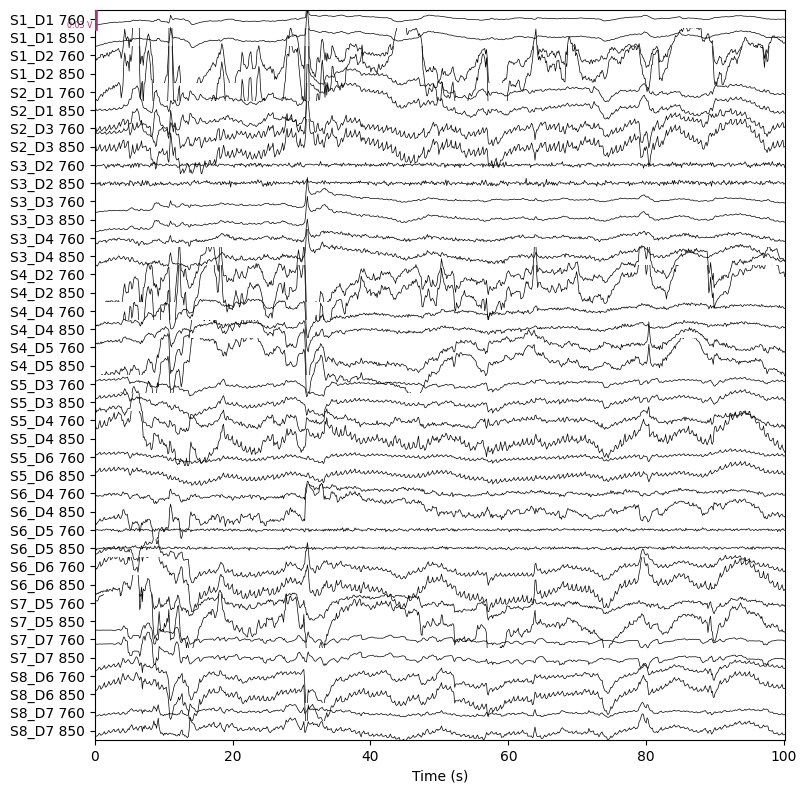

In [8]:
picks = mne.pick_types(raw_parent.info, meg=False, fnirs=True)
dists = mne.preprocessing.nirs.source_detector_distances(raw_parent.info, picks=picks)
raw_parent.pick(picks[dists > 0.01])
raw_parent.plot(n_channels=len(raw_parent.ch_names), duration=100, scalings='auto', show_scrollbars=False)
plt.show()

## Converting from raw intensity to optical density

After converting from raw intensity to optical density (OD), we apply the [TDDR filter](https://mne.tools/dev/generated/mne.preprocessing.nirs.temporal_derivative_distribution_repair.html) on OD data to remove motion artifacts. If you want to learn more about this filter you can look at this [paper](https://www.frontiersin.org/articles/10.3389/fnins.2022.878750/full).

Reading 0 ... 3712  =      0.000 ...   475.136 secs...


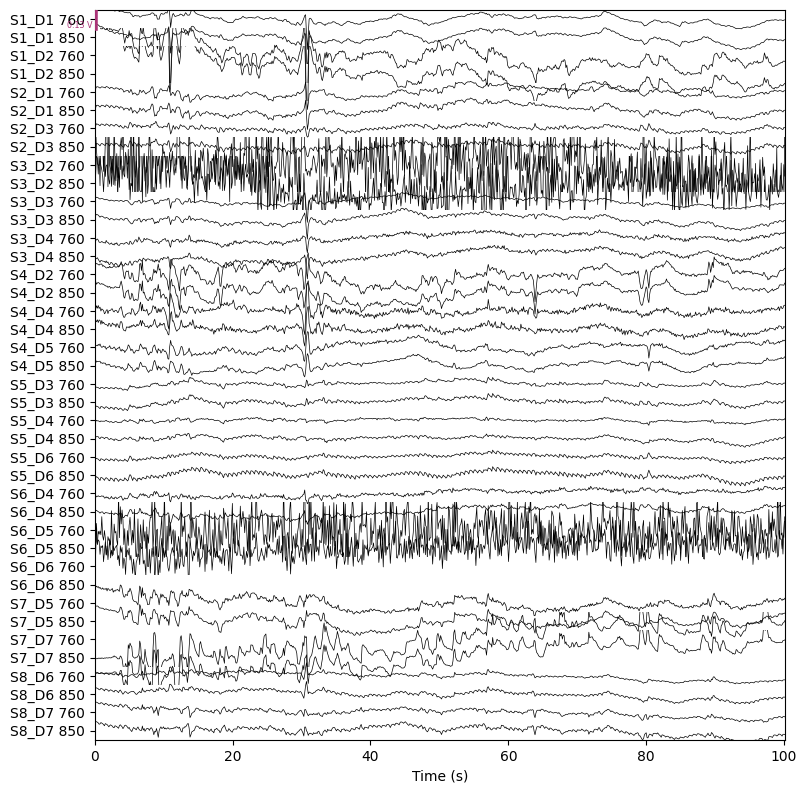

In [9]:
raw_opt = mne.preprocessing.nirs.optical_density(raw_parent)
raw_od = mne.preprocessing.nirs.temporal_derivative_distribution_repair(raw_opt, verbose=None) # Remove motion artifacts
raw_od.plot(n_channels=len(raw_od.ch_names), duration=100, scalings='auto', show_scrollbars=False)
plt.show()

Visually, we can see that `S3_D2 760, S3_D2 850, S6_D5 760, S6_D5 850, S6_D6 760, S6_D6 850` are noisy channels but let's check!

## Quality check

Note: The [scalp coupling index (SCI)](https://mne.tools/dev/generated/mne.preprocessing.nirs.scalp_coupling_index.html) looks for the presence of a prominent synchronous signal in the frequency range of cardiac signals across both photodetected signals. A common threshold for good quality is keeping channels with SCI > 0.5 (more details [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5175555/)).


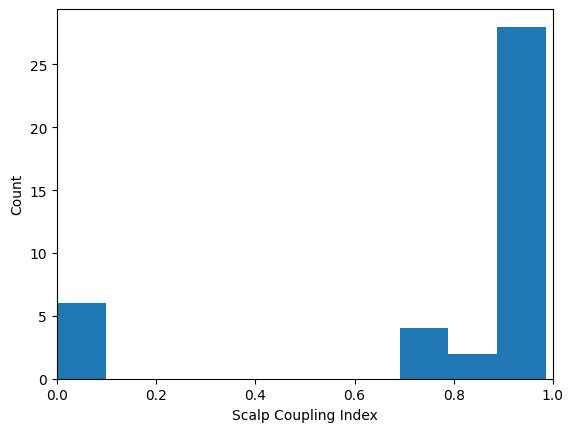

In [10]:
sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
fig, ax = plt.subplots()
ax.hist(sci)
ax.set(xlabel='Scalp Coupling Index', ylabel='Count', xlim=[0, 1])
plt.show()

You can also visualize it using a SCI matrix.

Here, all channels are represented on the y-axis and you can check their signal quality over time.

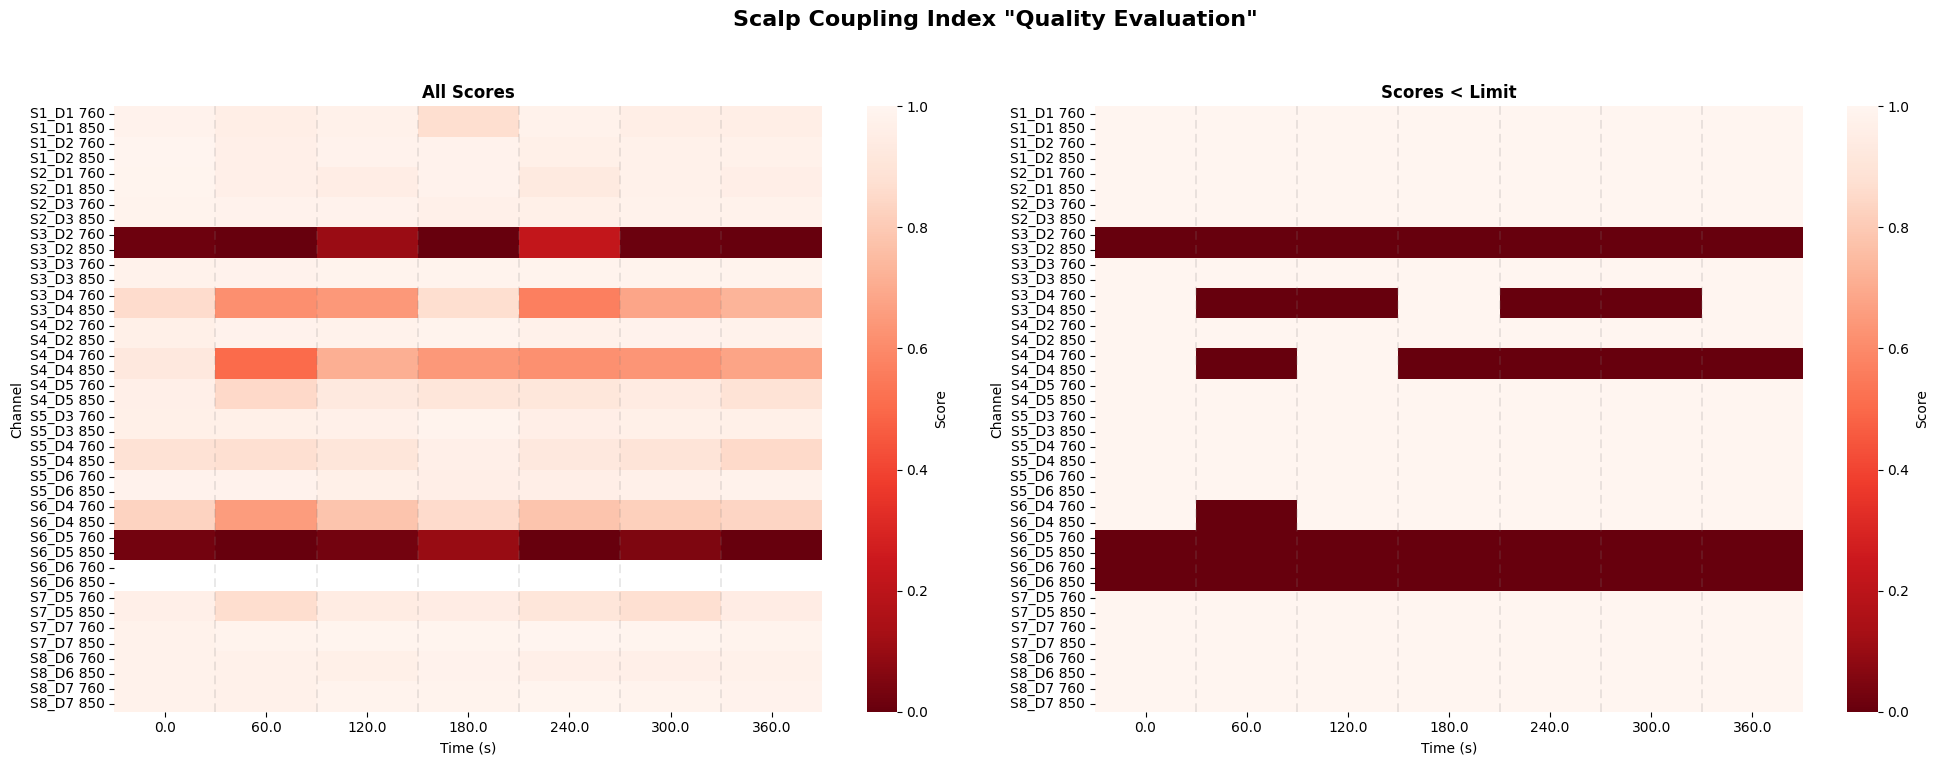

In [11]:
_, scores, times = scalp_coupling_index_windowed(raw_od, time_window=60)
plot_timechannel_quality_metric(raw_od, scores, times, threshold=0.7, title='Scalp Coupling Index "Quality Evaluation"')
plt.show()

Remove bad channels:

In [12]:
raw_od.info['bads'] = list(compress(raw_od.ch_names, sci < 0.5))
picks = mne.pick_types(raw_od.info, meg=False, fnirs=True, exclude='bads')
raw_od_clean = raw_od.copy().pick(picks)
print('The following channels were removed:',raw_od.info['bads'])

The following channels were removed: ['S3_D2 760', 'S3_D2 850', 'S6_D5 760', 'S6_D5 850', 'S6_D6 760', 'S6_D6 850']


## Converting from optical density to haemoglobin

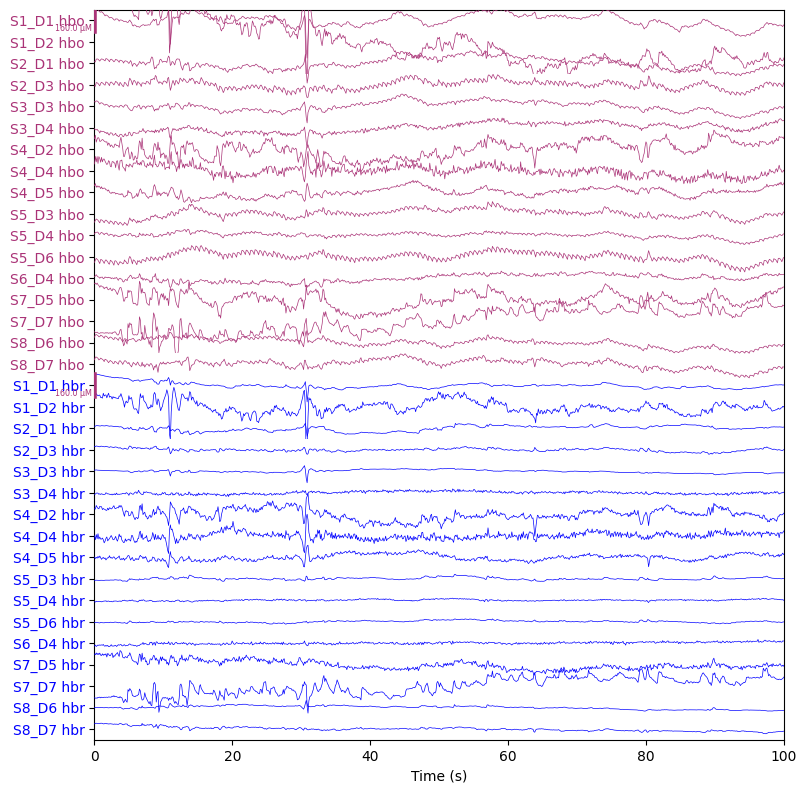

In [13]:
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od_clean, ppf=0.1)
raw_haemo.plot(n_channels=len(raw_haemo.ch_names), duration=100, scalings=dict(hbo=80e-6, hbr=80e-6), show_scrollbars=False, theme="light")
plt.show()

## Removing heart rate from signal

According to this [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7793571/pdf/NPh-008-012101.pdf), we apply a band-pass filter between 0.01 and 0.5 Hz.

Effective window size : 262.144 (s)
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.60 Hz)
- Filter length: 2579 samples (330.112 s)

Effective window size : 262.144 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:    0.0s finished


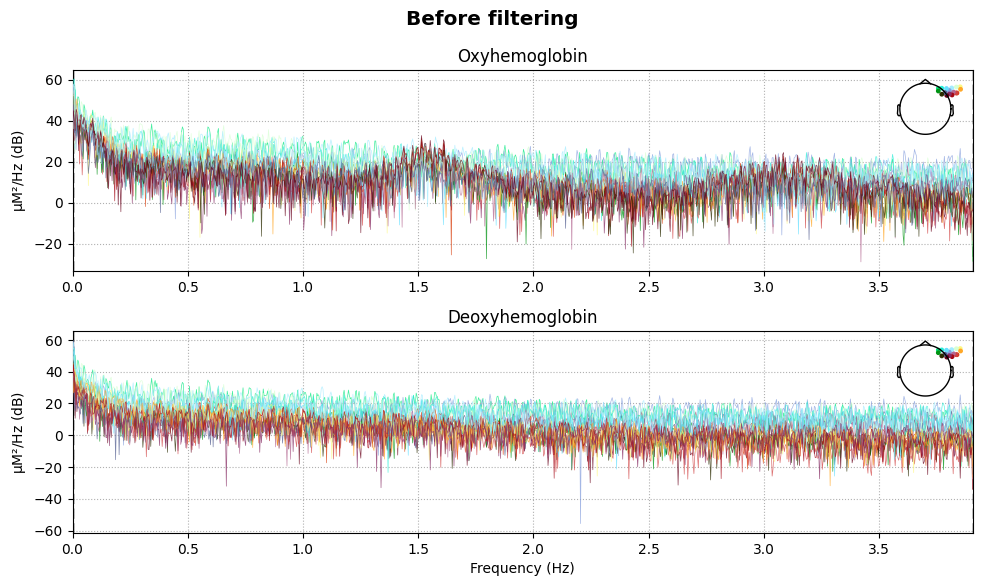

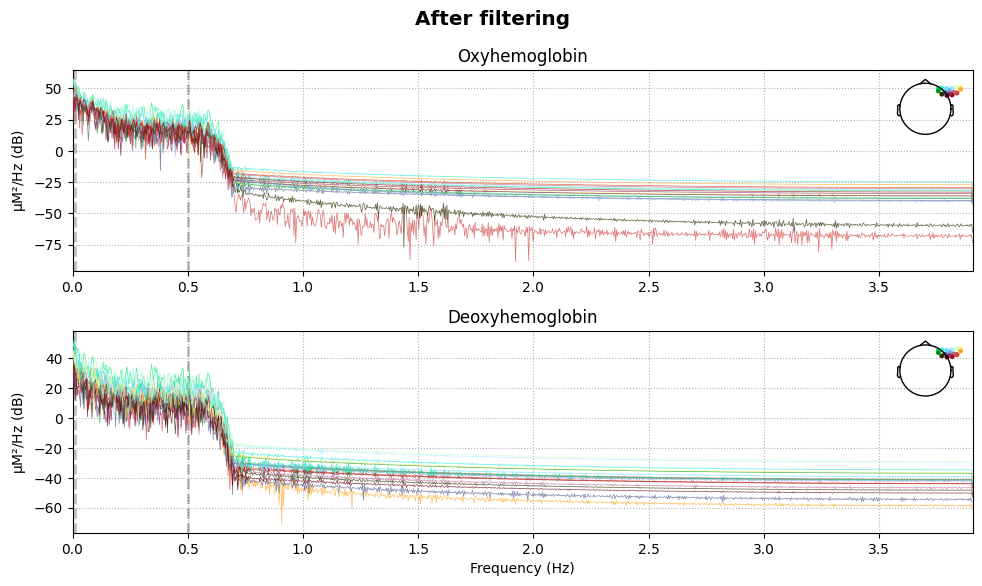

In [14]:
fig = raw_haemo.compute_psd().plot()
fig.suptitle('Before filtering', weight='bold', size='x-large')
fig.subplots_adjust(top=0.88)
raw_haemo_parent = raw_haemo.filter(0.01, 0.5, h_trans_bandwidth=0.2, l_trans_bandwidth=0.01)
fig = raw_haemo_parent.compute_psd().plot()
fig.suptitle('After filtering', weight='bold', size='x-large')
fig.subplots_adjust(top=0.88)
plt.show()

## Select HbO values only

For the next steps, we will be focused on the analysis of HbO **only** because it has been shown to be more sensitive to the changes in cerebral blood flow ([Jiang et al., 2012](https://www.jneurosci.org/content/32/45/16064)). However, as mentioned, [T. Nguyen et al. (2021)](https://www.mdpi.com/1424-8220/21/12/4075), we highly recommend repeating all analyses for HbR (and ideally Hb total) to derive a comprehensive picture of all possible neural synchronization processes (see this [paper](https://www.spiedigitallibrary.org/journals/neurophotonics/volume-9/issue-04/040601/Systematic-review-of-fNIRS-studies-reveals-inconsistent-chromophore-data-reporting/10.1117/1.NPh.9.4.040601.full?SSO=1) for a review).

In [15]:
raw_haemo_parent_hbo = raw_haemo_parent.copy().pick(picks='hbo')

## Do the same for the other participant

In [16]:
picks = mne.pick_types(raw_child.info, meg=False, fnirs=True)
dists = mne.preprocessing.nirs.source_detector_distances(raw_child.info, picks=picks)
raw_child.pick(picks[dists > 0.01])
raw_opt = mne.preprocessing.nirs.optical_density(raw_child)
raw_od = mne.preprocessing.nirs.temporal_derivative_distribution_repair(raw_opt, verbose=None) 
sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
raw_od.info['bads'] = list(compress(raw_od.ch_names, sci < 0.5))
picks = mne.pick_types(raw_od.info, meg=False, fnirs=True, exclude='bads')
raw_od_clean = raw_od.copy().pick(picks)
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od_clean, ppf=0.1)
raw_haemo_child = raw_haemo.filter(0.01, 0.5, h_trans_bandwidth=0.2, l_trans_bandwidth=0.01)
raw_haemo_child_hbo = raw_haemo_child.copy().pick(picks='hbo')

Reading 0 ... 3712  =      0.000 ...   475.136 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.60 Hz)
- Filter length: 2579 samples (330.112 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.0s finished


## Select common channels between both participants

We highly recommend this step in order to ensure that we have the same length of channels between both participants. Otherwise, there is a risk to not being able to run the wtc function correctly (following step).

In [17]:
n_channels_raw_haemo_parent_hbo = raw_haemo_parent_hbo.ch_names
n_channels_raw_haemo_child_hbo = raw_haemo_child_hbo.ch_names
common_channels = set(n_channels_raw_haemo_parent_hbo).intersection(set(n_channels_raw_haemo_child_hbo))

raw_haemo_common_channels_parent = raw_haemo_parent_hbo.copy().pick_channels(common_channels)
raw_haemo_common_channels_child = raw_haemo_child_hbo.copy().pick_channels(common_channels)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/var/folders/7_/lb0khj2n1p9fnkpgysdw0nj8x_dc2_/T/ipykernel_82802/3851259816.py:5: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw_haemo_common_channels_parent = raw_haemo_parent_hbo.copy().pick_channels(common_channels)
/var/folders/7_/lb0khj2n1p9fnkpgysdw0nj8x_dc2_/T/ipykernel_82802/3851259816.py:6: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw_haemo_common_channels_child = raw_haemo_child_hbo.copy().pick_channels(common_channels)


## Import into HyPyP

In [18]:
duration = 30
epo_child = mne.make_fixed_length_epochs(raw_haemo_common_channels_child, duration=duration, preload=True)
epo_parent = mne.make_fixed_length_epochs(raw_haemo_common_channels_parent, duration=duration, preload=True)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 234 original time points ...
0 bad epochs dropped
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 234 original time points ...
0 bad epochs dropped


## Compute and Visualize Cross-Wavelet Coherence

In [19]:
freq_bins = 10
freqs = np.linspace(0.01, 1, freq_bins)
sfreq = epo_child.info['sfreq']

data = hypyp.analyses.xwt(epo_child,
           epo_parent,
           freqs=freqs, sfreq=sfreq,
           analysis='wtc')

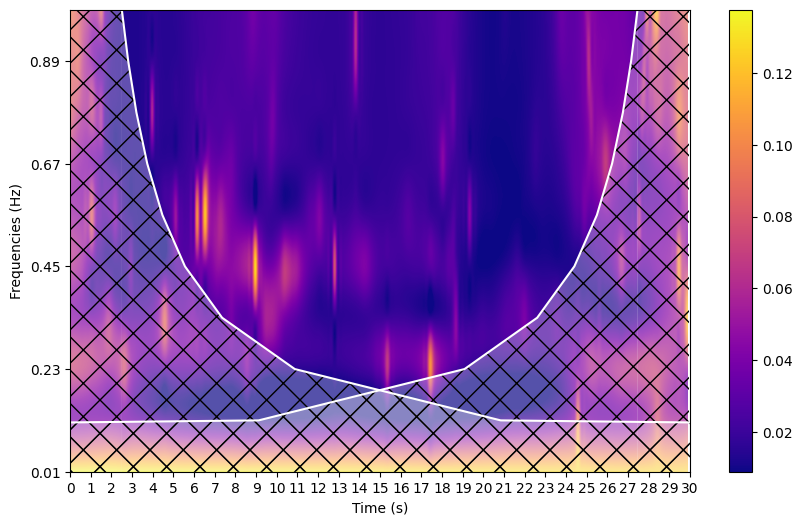

In [20]:
plt.figure(figsize=(10,6))

plt.imshow(np.abs(data).mean(0).mean(0),
           aspect='auto',
           cmap='plasma',
           interpolation='lanczos')

plt.gca().invert_yaxis()
plt.ylabel('Frequencies (Hz)')
plt.xlabel('Time (s)')
plt.yticks(range(0, freq_bins, 2), 
           np.round(100*freqs[range(0, freq_bins, 2)])/100)
plt.ylim([0, freq_bins-1])

smax = data.shape[-1]
plt.xlim([0, smax])
plt.xticks(np.arange(0, smax+sfreq, sfreq), range(duration+1))

coi = 2.5*sfreq/freqs
rev_coi = data.shape[-1]-coi
idx = np.arange(len(freqs))
plt.plot(coi, idx, 'w')
plt.plot(data.shape[-1]-coi, idx, 'w')
plt.fill_between(coi, idx, hatch='X', fc='w', alpha=0.3)
plt.fill_between(rev_coi, idx, hatch='X', fc='w', alpha=0.3)

plt.axvspan(0, min(coi), hatch='X', fc='w', alpha=0.3)
plt.axvspan(smax, max(rev_coi), hatch='X', fc='w', alpha=0.3)

plt.colorbar()
plt.show()

## Now, let's process all the dataset

In [21]:
def individual_preprocessing(raw_data):
    picks = mne.pick_types(raw_data.info, meg=False, fnirs=True)
    dists = mne.preprocessing.nirs.source_detector_distances(raw_data.info, picks=picks)
    raw_data.pick(picks[dists > 0.01])
    raw_opt = mne.preprocessing.nirs.optical_density(raw_data)
    raw_od = mne.preprocessing.nirs.temporal_derivative_distribution_repair(raw_opt, verbose=None)
    sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
    raw_od.info['bads'] = list(compress(raw_od.ch_names, sci < 0.5))
    picks = mne.pick_types(raw_od.info, meg=False, fnirs=True, exclude='bads')
    raw_od_clean = raw_od.copy().pick(picks)
    raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od_clean, ppf=0.1)
    raw_haemo_filtered = raw_haemo.filter(0.01, 0.5, h_trans_bandwidth=0.2, l_trans_bandwidth=0.01)
    raw_haemo_hbo = raw_haemo_filtered.copy().pick(picks='hbo')

    return raw_haemo_hbo

In [22]:
%%capture
# We expect to get 58 files (representing 29 dyads):
print('This list is composed by',len(raw_data),'files (participants) corresponding to', int(len(raw_data)/2), 'dyads.')

print(raw_data) # We can see that the parent-child data are alternated

# Retrieve children data
children_data = raw_data[::2]

# Do the reverse to get the parents data only 
parents_data = raw_data[::-2]

# Create two empty lists to store 'raw_haemo_hbo' from all parents and children separately 
raw_haemo_hbo_children = []
raw_haemo_hbo_parents = []

In [23]:
%%capture 
# Run data preprocessing for all participants
for parent in parents_data:
    raw_haemo_hbo = individual_preprocessing(parent)
    raw_haemo_hbo_parents.append(raw_haemo_hbo)
for child in children_data:
    raw_haemo_hbo = individual_preprocessing(child)
    raw_haemo_hbo_children.append(raw_haemo_hbo)

Before connectivity analyses, we're going to pair each child data with their father data.

In [24]:
true_dyads = []
raw_haemo_hbo_parents = list(reversed(raw_haemo_hbo_parents))
for dyad in range (len(raw_haemo_hbo_parents)):
    true_dyads.append((raw_haemo_hbo_parents[dyad], raw_haemo_hbo_children[dyad]))

You can manually check if the pairing is correct:

In [25]:
d = true_dyads[9] # Dyad number
d[0].info['subject_info'] # d[0] = Father, d[1] = Child

{'his_id': 'FCS26FP',
 'first_name': 'FCS26FP',
 'sex': 0 (FIFFV_SUBJ_SEX_UNKNOWN),
 'birthday': (2019, 11, 30)}

Let's select common channels only:

In [26]:
%%capture
true_dyads_common_channels_parents = []
true_dyads_common_channels_children = []

for dyad in range (len(true_dyads)):
    n_channels_raw_haemo_parents_hbo = raw_haemo_hbo_parents[dyad].ch_names
    n_channels_raw_haemo_children_hbo = raw_haemo_hbo_children[dyad].ch_names
    common_channels = set(n_channels_raw_haemo_parents_hbo).intersection(set(n_channels_raw_haemo_children_hbo))

    raw_haemo_common_channels_parents = raw_haemo_hbo_parents[dyad].copy().pick_channels(common_channels)
    raw_haemo_common_channels_children = raw_haemo_hbo_children[dyad].copy().pick_channels(common_channels)
    true_dyads_common_channels_parents.append(raw_haemo_common_channels_parents)
    true_dyads_common_channels_children.append(raw_haemo_common_channels_children)

Make a function that creates 30s epochs and perform IBS calculation:

In [27]:
def IBS_calculation(child, parent):
    duration = 30 # epoch duration
    freq_bins = 10
    freqs = np.linspace(0.01, 1, freq_bins) # frequency band of interest
    epo_child = mne.make_fixed_length_epochs(child, duration=duration, preload=False)
    epo_parent = mne.make_fixed_length_epochs(parent, duration=duration, preload=False)
    data = hypyp.analyses.xwt(epo_child, epo_parent, freqs=freqs, sfreq=sfreq, analysis='wtc')
    return data

Use this function to calculate IBS for all dyads:

In [28]:
%%capture
# Create an empty list to store wtc values for all dyads
wtc_true_dyads = []

# Run wtc analysis for all dyads
for dyad in range(min(len(true_dyads_common_channels_children), len(true_dyads_common_channels_parents))):
    child = true_dyads_common_channels_children[dyad]
    parent = true_dyads_common_channels_parents[dyad]
    wtc_values = IBS_calculation(child, parent)
    wtc_true_dyads.append(wtc_values)

## Statistical Analysis and Visualization

> To be continued...